In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

from codes.gate_design import gate_coords
from codes.constants import scale
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index
from codes.utils import order_wavefunctions, ratio_Gaussian_curvature

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from scipy.optimize import minimize

In [3]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [5]:
system = trijunction.Trijunction(config, optimize_phase_pairs=[])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:34<00:00,  2.64s/it]


### Maximize couplings

In [8]:
pair = 'left-right'
voltages = parameters.pair_voltages()

In [9]:
zero_potential = dict(
    zip(
        ta.array(system.site_coords[:, [0, 1]] - system.offset),
        np.zeros(len(system.site_coords)),
    )
)

In [10]:
kwant_args = list(system.optimiser_arguments().values())
kwant_args[-1] = kwant_args[-1][order_wavefunctions(pair)]

In [11]:
x = [-1.0e-3, -1.0e-3, -5.0e-3, 3e-3]
voltages = parameters.voltage_dict(x)

In [44]:
params = parameters.junction_parameters()
params.update(voltages)
params.update(potential=zero_potential)

In [13]:
opt_args = tuple([pair, params, kwant_args, 0.0])

In [47]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])
soft_threshold_indices = dep_acc_index(
    zip(system.gate_names, system.gates_vertex),
    system.nw_centers,
               kwant_sites,
               config['gate']['angle'],
               scale,
               10
               )

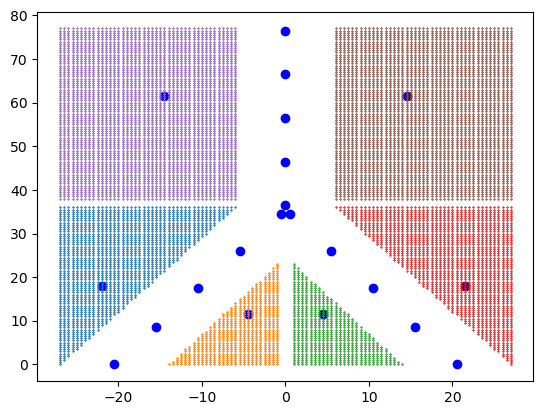

In [48]:
site_coords = system.grid_points[system.site_indices]
for index in np.hstack(list(soft_threshold_indices.values())):
    point = kwant_sites[index]/scale
    plt.scatter(point[0], point[1], c='b')

for key, value in system.poisson_system.regions.voltage.tag_points.items():
    if not key.startswith(('global', 'dirichlet')):
        coords = system.grid_points[value]
        plt.scatter(coords[:, 0], coords[:, 1], s = 0.1)

In [49]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])/scale
params.update({'dep_acc_index': soft_threshold_indices})

In [50]:
step_size = 1e-4
opt_args = tuple((pair, params, kwant_args, 0.0, step_size))
# optimization.loss(x, *opt_args)

In [93]:
import codes.optimization
import importlib
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [94]:
sol1 = minimize(
            codes.optimization.loss,
            x,
            args=opt_args,
            method="trust-constr",
            # jac=codes.optimization.jacobian,
            options={
                "verbose":2,
                "initial_tr_radius":1e-3,
            },
        )

[-0.001 -0.001 -0.005  0.003]
7.286037226605733e-06 4.183143487672815e-08
[-0.00100001 -0.001      -0.005       0.003     ]
7.286336304414348e-06 4.183132390122988e-08
[-0.001      -0.00100001 -0.005       0.003     ]
7.286336304414571e-06 4.183097231955e-08
[-0.001      -0.001      -0.00500001  0.003     ]
7.2860730102141695e-06 4.183138863010693e-08
[-0.001      -0.001      -0.005       0.00300001]
7.285933509414634e-06 4.183168827484551e-08
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +2.5183e+00 | 1.00e-03 | 2.93e+02 | 0.00e+00 |
[-0.00168504 -0.00168586 -0.00508084  0.00276809]
1.2895414493918972e-05 2.6115824960818682e-08
[-0.00168506 -0.00168586 -0.00508084  0.00276809]
1.289578496597586e-05 2.6114083399721864e-08
[-0.00168504 -0.00168587 -0.00508084  0.00276809]
1.2895784954906715e-05 2.6115598807597626e-08
[-0.00168504 -0.00168586 -0.00508085  0.002768

In [70]:
deltaV = np.linspace(-2, 5, 100) * 1e-3
scattering_region_density = kwant.operator.Density(system.trijunction, where=bounds)
kwant_sites = np.array([site.pos for site in system.trijunction.sites])

In [95]:
from tqdm import tqdm

In [239]:
# wave_functions = []
# ratios = []
# desired_couplings = []
# undesired_couplings = []
shape, loss = [], []
for v in tqdm(deltaV):
    a, b = codes.optimization.loss([-0.00343678 + v, 
                                    -0.00343654 + v, 
                                    -0.01941018,  
                                    0.00980045], 
                                   *opt_args
                                  )
    shape.append(a)
    loss.append(b)
#     params.update(parameters.voltage_dict([-0.00343678 + v, 
#                                            -0.00343654 + v, 
#                                            -0.01941018,  
#                                            0.00980045]))
#     linear_ham, numerical_hamiltonian = hamiltonian(system.trijunction, 
#                                     optimiser_args['linear_terms'], 
#                                     optimiser_args['kwant_params_fn'], 
#                                     **params)
#     energies, wave_function = eigsh(
#                 numerical_hamiltonian.tocsc(),
#                 6,
#                 sigma=0,
#                 return_eigenvectors=True,
#     )
#     transformed_hamiltonian = svd_transformation(
#     energies, wave_function, system.mlwf[order_wavefunctions('left-right')]
#     )

#     desired_couplings.append(np.abs(transformed_hamiltonian[0, 1]))
#     undesired_couplings.append(np.linalg.norm(transformed_hamiltonian[2:]))
    
#     step = system.geometry['grid_spacing']*scale

#     xmin, xmax, ymin, ymax = np.array(list(system.boundaries.values()))*scale
#     bounds = lambda site: (site.pos[0] > xmin 
#                         and site.pos[0] < xmax
#                         and site.pos[1] > ymin
#                         and site.pos[1] < ymax)
    
    
#     wavefunction_density = scattering_region_density(wave_function[:, 0])

#     scattering_sites = kwant_sites[[bounds(site) for site in system.trijunction.sites]]
#     x, y = scattering_sites[:, 0], scattering_sites[:, 1]
#     nx, ny = len(np.unique(x)), len(np.unique(y))

#     interpolated_wavefunction = wavefunction_density.reshape((nx, -1))
    
#     ratios.append(ratio_Gaussian_curvature(interpolated_wavefunction, step))


100%|██████████| 100/100 [13:39<00:00,  8.20s/it]


Text(0.5, 0, 'Detuning (V)')

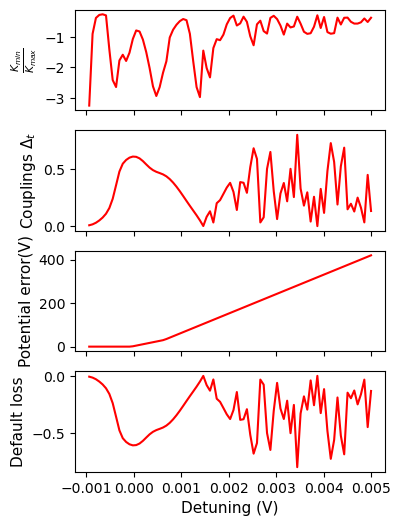

In [242]:
fig, ax = plt.subplots(4, 1, figsize=(4, 6), sharex=True)
r = 15
ax[0].plot(deltaV[r:], ratios[r:], '-', c='r')
# ax[0].vlines(0.0, -5, -0.5, 'r')

ax[0].set_ylabel(r'$\frac{K_{min}}{K_{max}}$', fontsize=11)

ax[1].plot(deltaV[r:], np.array(desired_couplings)[r:]/40e-6, '-', c='r')
ax[1].set_ylabel(r'Couplings $\Delta_t$', fontsize=11)


ax[2].plot(deltaV[r:], np.array(shape)[r:]/40e-6, '-', c='r')
ax[2].set_ylabel('Potential error(V)', fontsize=11)

ax[3].plot(deltaV[r:],( np.array(loss) - np.array(shape))[r:]/40e-6, '-', c='r')
ax[3].set_ylabel('Default loss', fontsize=11)

ax[3].set_xlabel('Detuning (V)', fontsize=11)

In [88]:
params.update(parameters.voltage_dict(sol1.x))
linear_ham, numerical_hamiltonian = hamiltonian(system.trijunction, 
                                optimiser_args['linear_terms'], 
                                optimiser_args['kwant_params_fn'], 
                                **params)

In [89]:
energies, wave_function = eigsh(
                numerical_hamiltonian.tocsc(),
                6,
                sigma=0,
                return_eigenvectors=True,
    )

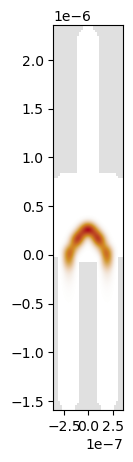

In [90]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5), sharey= True)

density = kwant.operator.Density(system.trijunction, np.eye(4))
for i, vec in enumerate(wave_function.T[[0]]):
    kwant.plotter.density(system.trijunction, density(vec), ax=ax);


In [81]:
transformed_hamiltonian = svd_transformation(
    energies, wave_function, system.mlwf[order_wavefunctions('left-right')]
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

### Initial voltage guess

In [6]:
kwant_sites = [site.pos for site in system.trijunction.sites]

In [7]:
gates_dict = zip(system.gate_names, system.gates_vertex)
indices = dep_acc_index(
    gates_dict,
    system.nw_centers,
    kwant_sites,
    config['gate']['angle'],
    shift=3,
    spacing = 3,
    npts=5
)

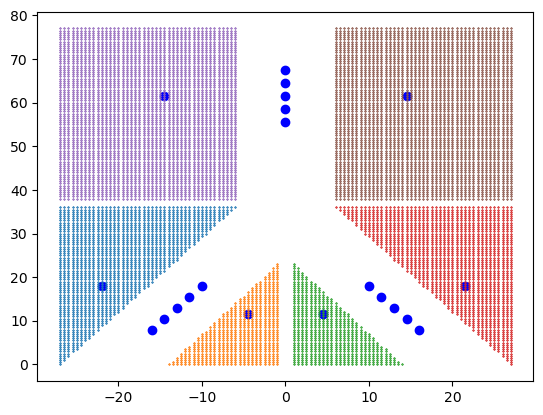

In [8]:
site_coords = system.grid_points[system.site_indices]
for gate, index in indices.items():
    point = kwant_sites[index]/scale
    plt.scatter(point[0], point[1], c='b')

for key, value in system.poisson_system.regions.voltage.tag_points.items():
    if not key.startswith(('global', 'dirichlet')):
        coords = system.grid_points[value]
        plt.scatter(coords[:, 0], coords[:, 1], s = 0.1)

In [9]:
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())
# base_ham = system.trijunction.hamiltonian_submatrix(
#     sparse=True, params=system.f_params(**params)
# )
args = ((system.base_ham, system.linear_terms), 
        system.densityoperator, 
        indices, 
        ['top', 'right'])

In [10]:
initial_condition = (-1.5e-3, -1.5e-3, -1.5e-3, 3e-3)

In [12]:
from codes.optimization import soft_threshold_loss

In [13]:
%%time

sol1 = minimize(soft_threshold_loss, 
         x0=initial_condition, 
         args=args, 
         method='trust-constr', 
         options={'initial_tr_radius':1e-3,
                  'verbose':2}
        )

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +1.9176e-02 | 1.00e-03 | 4.70e+00 | 0.00e+00 |
|   2   |  10   |   1   | +1.3233e-02 | 7.00e-03 | 4.70e+00 | 0.00e+00 |
|   3   |  15   |   2   | +5.6460e-03 | 7.00e-03 | 3.35e+00 | 0.00e+00 |
|   4   |  20   |   4   | +5.2242e-03 | 7.00e-03 | 1.95e+00 | 0.00e+00 |
|   5   |  25   |   6   | -4.5705e-05 | 1.40e-02 | 1.52e+00 | 0.00e+00 |
|   6   |  30   |   8   | -4.5705e-05 | 6.14e-03 | 1.52e+00 | 0.00e+00 |
|   7   |  35   |  10   | -4.5705e-05 | 3.07e-03 | 1.52e+00 | 0.00e+00 |
|   8   |  40   |  11   | -4.5705e-05 | 1.54e-03 | 1.52e+00 | 0.00e+00 |
|   9   |  45   |  12   | -1.0000e+00 | 1.07e-02 | 0.00e+00 | 0.00e+00 |

`gtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 45, CG iterations: 12, optimality: 0.00e+00, constraint violation: 0.00e+00, execution time: 5.8e+01 s.


In [14]:
optimal_voltages = parameters.voltage_dict(sol1.x)

In [16]:
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())
params.update(optimal_voltages)

In [18]:
from codes.constants import bands


In [19]:
linear_ham, full_ham = hamiltonian(system.base_ham, 
                                   system.linear_terms, 
                                   system.f_params, 
                                   **params)

potential = linear_ham.diagonal()[::4]
step_potential = np.array(np.abs(potential) > bands[0], dtype=int)

In [21]:
evals, evecs = eigsh(full_ham, k=6, sigma=0, return_eigenvectors=True)

In [22]:
transformed_hamiltonian = svd_transformation(
    evals, evecs, system.mlwf[order_wavefunctions('right-top')]
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

In [23]:
desired, undesired

(8.381095441027058e-06, 3.3195351923493304e-08)

In [24]:
wfv = system.densityoperator(evecs[:, -1])

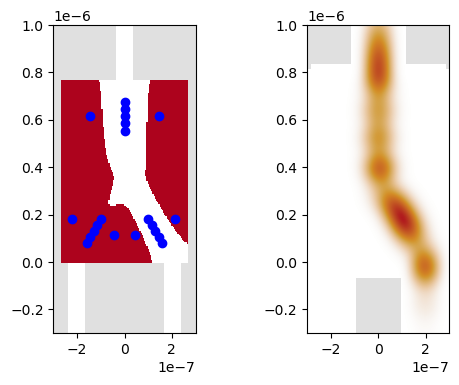

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 4))
kwant.plotter.map(system.trijunction, lambda i: step_potential[i], ax=ax[0])
kwant.plotter.density(system.trijunction, wfv, ax=ax[1]);
for value in indices.values():
    ax[0].scatter(*kwant_sites[value], c='blue')
for axes in ax:
    axes.set_ylim(-3e-7, 10e-7)
    axes.set_xlim(-3e-7, 3e-7)